# Confidence Interval of Dissociation Constant
by
Bootstrapping of concentration series-based measurements of the molecular interaction according to Hill

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from resampling.bootstrap import Bootstrap
from resampling.hill import Hill

## Load data
Load data from File

In [2]:
sampleNumber = 100
dfRaw = pd.read_excel("/home/malkusch/PowerFolders/Met-HMM/modeling/Data/191108_HMM_FCSdata_MET_InlB321-ATTO647N.xlsx",
                          index_col = None,
                          header=0,
                          sheet_name = "Tabelle2")
    
dfRaw = dfRaw[dfRaw["date"] == 120908]
dfRaw = dfRaw[dfRaw["MET [nM]"] > 0.0]
dfRaw = dfRaw[['date', 'MET [nM]', 'tauD1', 'tauD2', 'tauD3']]
dfRaw = dfRaw.sort_values(by=['MET [nM]'])



dfRaw

,date,MET [nM],tauD1,tauD2,tauD3
1,120908,0.0153,NaN,1.62857,1.57731
2,120908,0.1530,1.62760,1.68224,1.72654
3,120908,1.5300,2.13401,2.07158,2.06526
8,120908,3.0600,2.28463,2.44971,2.51875
9,120908,7.6500,3.33672,3.16010,3.16174
4,120908,15.3000,3.49146,3.41999,3.39549
7,120908,30.6000,3.68663,3.80199,3.62211
12,120908,45.9000,3.82506,3.71056,3.66766
11,120908,76.5000,3.95057,3.91103,3.97010
5,120908,153.0000,4.01414,3.99803,3.97497


## Display NaN statistics

In [3]:
df_na = pd.DataFrame({'na count': dfRaw.isna().sum()})
df_na['na fraction'] = df_na['na count'] / dfRaw.shape[0]
df_na

,na count,na fraction
date,0,0.000000
MET [nM],0,0.000000
tauD1,1,0.083333
tauD2,0,0.000000
tauD3,0,0.000000


## Replace NaN
by mean of remaining

In [4]:
#values = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
meanValues = dfRaw[['tauD1', 'tauD2', 'tauD3']].mean(axis=1)
dfRaw = dfRaw.T.fillna(value = meanValues).T
dfRaw

,date,MET [nM],tauD1,tauD2,tauD3
1,120908.0,0.0153,1.60294,1.62857,1.57731
2,120908.0,0.1530,1.62760,1.68224,1.72654
3,120908.0,1.5300,2.13401,2.07158,2.06526
8,120908.0,3.0600,2.28463,2.44971,2.51875
9,120908.0,7.6500,3.33672,3.16010,3.16174
4,120908.0,15.3000,3.49146,3.41999,3.39549
7,120908.0,30.6000,3.68663,3.80199,3.62211
12,120908.0,45.9000,3.82506,3.71056,3.66766
11,120908.0,76.5000,3.95057,3.91103,3.97010
5,120908.0,153.0000,4.01414,3.99803,3.97497


## Resample with replacement

In [5]:
bs = Bootstrap()
bs.seed = 42
bs.data = dfRaw[['tauD1', 'tauD2', 'tauD3']].to_numpy()
rsData = np.zeros([dfRaw.shape[0], sampleNumber+1])
rsData[:,0] = dfRaw['MET [nM]'].to_numpy()
rsData[:,1:] = bs.resample(number = sampleNumber)

## Modeling
with Hill Equation

In [6]:
modelLst = []
for i in range(sampleNumber):
    model = Hill()
    model.data = rsData[:,(0,i+1)]
    model.thetaLgnd = 1.64
    model.n = 1
    model.initKd = 5.0
    model.initThetaCmplx = 4.0
    model.fitMLE()
    modelLst.append(model)
    
index = []
for i in range(sampleNumber):
    modelName = i #str('model_%i' %(i))
    index.append(modelName)
    
columns = ('fitSuccess', 'Kd', 'Ka', 'n', 'tauLigand', 'tauComplex', 'logL', 'BIC', 'AIC', 'AICc', 'rmse')
df_model = pd.DataFrame(index=index, columns=columns).fillna(value = 0.0)



for i in range(sampleNumber):
    df_model.loc[index[i]] = ({'fitSuccess': modelLst[i].fitSuccess,
                               'Kd': modelLst[i].kd,
                               'Ka': modelLst[i].ka,
                               'n': modelLst[i].n,
                               'tauLigand': modelLst[i].thetaLgnd,
                               'tauComplex': modelLst[i].thetaCmplx,
                               'logL': modelLst[i].logL,
                               'BIC': modelLst[i].bic,
                               'AIC': modelLst[i].aic,
                               'AICc': modelLst[i].aicc,
                               'rmse': modelLst[i].rmse})
    
df_model = df_model.astype({'fitSuccess': 'bool',
                            'Kd': 'float64',
                            'Ka': 'float64',
                            'n': 'int32',
                            'tauLigand': 'float64',
                            'tauComplex': 'float64',
                            'logL': 'float64',
                            'BIC': 'float64',
                            'AIC': 'float64',
                            'AICc': 'float64',
                            'rmse': 'float64'})                               
    
df_model

,fitSuccess,Kd,Ka,n,tauLigand,tauComplex,logL,BIC,AIC,AICc,rmse
0,True,4.298223,4.298223,1,1.64,3.897949,10.796526,-16.623239,-17.593053,-16.259719,0.098380
1,True,5.233679,5.233679,1,1.64,3.934945,8.116483,-11.263152,-12.232965,-10.899632,0.118935
2,True,5.186762,5.186762,1,1.64,3.969429,8.887982,-12.806150,-13.775963,-12.442630,0.113400
3,True,5.189958,5.189958,1,1.64,3.945516,5.802031,-6.634250,-7.604063,-6.270730,0.134175
4,True,5.007850,5.007850,1,1.64,3.935488,6.857668,-8.745523,-9.715337,-8.382003,0.127450
...,...,...,...,...,...,...,...,...,...,...,...
95,True,4.441241,4.441241,1,1.64,3.932940,5.510369,-6.050924,-7.020737,-5.687404,0.135974
96,True,4.784129,4.784129,1,1.64,3.939760,8.929605,-12.889397,-13.859211,-12.525877,0.113094
97,True,3.903970,3.903970,1,1.64,3.890922,5.850675,-6.731537,-7.701350,-6.368017,0.133872
98,True,4.440373,4.440373,1,1.64,3.894928,9.808530,-14.647247,-15.617060,-14.283727,0.106421


## Model Statistics

In [7]:
df_model.describe()

,Kd,Ka,n,tauLigand,tauComplex,logL,BIC,AIC,AICc,rmse
count,100.000000,100.000000,100.0,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.584847,4.584847,1.0,1.640000e+00,3.932501,6.561343,-8.152873,-9.122686,-7.789353,0.128333
std,0.347521,0.347521,0.0,2.454795e-15,0.021506,2.574477,5.148955,5.148955,5.148955,0.016454
min,3.841523,3.841523,1.0,1.640000e+00,3.878295,-0.642427,-17.908986,-18.878799,-17.545466,0.092775
25%,4.350795,4.350795,1.0,1.640000e+00,3.918376,5.316438,-11.936187,-12.906000,-11.572667,0.116553
50%,4.528950,4.528950,1.0,1.640000e+00,3.933418,6.555526,-8.141238,-9.111051,-7.777718,0.129410
75%,4.844605,4.844605,1.0,1.640000e+00,3.945791,8.453000,-5.663063,-6.632876,-5.299543,0.137158
max,5.303899,5.303899,1.0,1.640000e+00,3.975631,11.439400,6.254668,5.284855,6.618188,0.169540


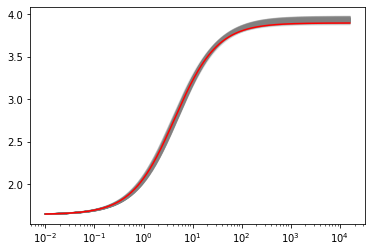

In [8]:
cLig = np.arange(0.01, 16000, 0.01)
for i in range(sampleNumber):
    plt.plot(cLig, modelLst[i].predict(cLig), c='grey', alpha=0.2)
    
plt.plot(cLig, modelLst[0].predict(cLig), c='red')

plt.xscale(value = 'log')
plt.show()

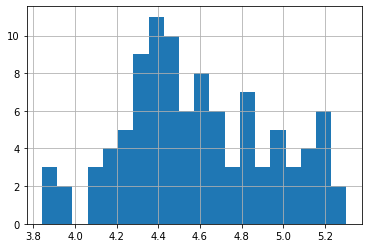

In [9]:
df_model['Kd'].hist(bins = 20)